<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/TextCNN_with_Word2Vec_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Important sorces:
https://chatgpt.com/share/21220a6d-4cca-48bc-b461-bca6b0e140bc

In [ ]:
pip install gensim

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from gensim.models import Word2Vec
from sklearn.metrics import classification_report


# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
class_distribution = dataset['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())


                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(lemmatized)


# Ensure all values in 'Question_body' are strings and handle NaNs and # Convert 'Question_body' to string (to avoid NaN issues)
dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)


# Tokenize the text and train Word2Vec model

In [ ]:
# Extract the text
texts = dataset['Question_body_preprocessed'].astype(str).tolist()

# Tokenize the text and train Word2Vec model
tokenized_texts = [text.split() for text in texts]
word2vec_model = Word2Vec(tokenized_texts, vector_size=200, window=5, min_count=1, workers=4)

# Create an embedding matrix

In [ ]:
# Create an embedding matrix
vocab_size = len(word2vec_model.wv.key_to_index) + 1
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = {word: index for index, word in enumerate(word2vec_model.wv.index_to_key, 1)}

for word, index in word_index.items():
    embedding_matrix[index] = word2vec_model.wv[word]

# Split the data into training and testing sets

In [ ]:
# Convert text to sequences of word indexes
sequences = [[word_index.get(word, 0) for word in text] for text in tokenized_texts]
# Pad the sequences to ensure uniform input size
max_len = 100  # Maximum length of all sequences
data = pad_sequences(sequences, maxlen=max_len)


# Split the data into training and testing sets
# Extract the text and labels
labels = dataset['Label'].tolist()
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the TextCNN model

In [ ]:
def create_model_Word2Vec(vocab_size, embedding_dim, max_len, embedding_matrix):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(embedding)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(embedding)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create the model
model = create_model_Word2Vec(vocab_size, embedding_dim, max_len, embedding_matrix)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Train the model

In [ ]:
import numpy as np

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_train)
y_test = np.array(y_train)


In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
#history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test),  callbacks=[early_stopping])


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 183ms/step - accuracy: 0.9741 - loss: 0.1098 - val_accuracy: 0.9946 - val_loss: 0.0232
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 78s 172ms/step - accuracy: 0.9893 - loss: 0.0346 - val_accuracy: 0.9976 - val_loss: 0.0099
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - accuracy: 0.9929 - loss: 0.0211 - val_accuracy: 0.9976 - val_loss: 0.0074
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 173ms/step - accuracy: 0.9966 - loss: 0.0122 - val_accuracy: 0.9987 - val_loss: 0.0043
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.9945 - loss: 0.0162 - val_accuracy: 0.9985 - val_loss: 0.0047
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 64s 172ms/step - accuracy: 0.9955 - loss: 0.0130 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - accuracy: 0.9965 - loss: 0.0087 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 88s 184ms/step - accuracy: 0.9966 - loss: 0

# Evaluate the model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

374/374 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9993 - loss: 0.0028
Test Accuracy: 0.9993


# Make predictions on New data

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Assuming the model has already been trained
# Predict the test set
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print classification report
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Compute precision, recall, and f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

print('------------------------------------------------------------------')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Accuracy: {accuracy:.4f}')


374/374 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5969
           1       1.00      1.00      1.00      5976

    accuracy                           1.00     11945
   macro avg       1.00      1.00      1.00     11945
weighted avg       1.00      1.00      1.00     11945

Confusion Matrix:
[[5964    5]
 [   3 5973]]
------------------------------------------------------------------
Precision: [0.99949723 0.9991636 ]
Recall: [0.99916234 0.99949799]
F1-score: [0.99932976 0.99933077]
Accuracy: 0.9993


In [ ]:
# Calculate precision, recall, and F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 0', 'Class 1'])
print(report)

NameError: name 'y_true_classes' is not defined

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Calculate precision, recall, f1-score, and support
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true_classes, y_pred_classes, average=None)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate class-wise accuracy
accuracy_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
accuracy_class_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if (conf_matrix[1, 1] + conf_matrix[1, 0]) > 0 else 0

# Compute overall accuracy
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Print metrics
print(f'Class 0 - Precision: {precision_class[0]:.4f}, Recall: {recall_class[0]:.4f}, F1-score: {f1_class[0]:.4f}, Support: {support_class[0]}, Accuracy: {accuracy_class_0:.4f}')
print(f'Class 1 - Precision: {precision_class[1]:.4f}, Recall: {recall_class[1]:.4f}, F1-score: {f1_class[1]:.4f}, Support: {support_class[1]}, Accuracy: {accuracy_class_1:.4f}')
print(f'Overall Accuracy: {accuracy:.3f}')

Class 0 - Precision: 0.9443, Recall: 0.8838, F1-score: 0.9130, Support: 1497, Accuracy: 0.8838
Class 1 - Precision: 0.8903, Recall: 0.9477, F1-score: 0.9181, Support: 1490, Accuracy: 0.9477
Overall Accuracy: 0.916


In [ ]:
# Save the model
model.save('word2vec_textcnn_model.h5')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# Calculate precision, recall, f1-score, and support (overall)
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='binary')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Compute overall accuracy
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Print overall metrics
# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')

Overall Precision: 0.8902900378310215
Overall Recall: 0.9476510067114094
Overall F1-score: 0.918075422626788
Overall Accuracy: 0.9156344158018078


# Prediction results analysis with Confusion Matric

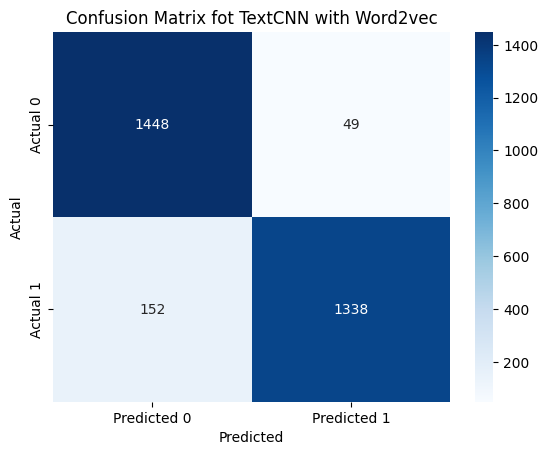

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_test is in binary format
y_true_classes = y_test.argmax(axis=1)  # Convert y_test to binary labels

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of TextCNN with Word2vec')
plt.show()

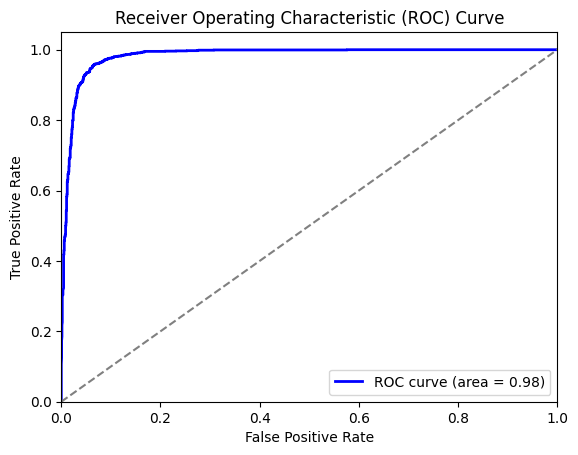

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming binary classification
# Convert one-hot encoded labels to binary labels (0 or 1)
y_pred_prob = y_pred[:, 1]  # Use the probability of the positive class (index 1)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from bs4 import BeautifulSoup


# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Load dataset
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')
print(dataset['Label'].value_counts())


Label
0    7466
1    7466
Name: count, dtype: int64


In [ ]:
# Clean HTML tags and replace them with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    for a in soup.find_all('a'):
        a.replace_with('[external-link]')
    for img in soup.find_all('img'):
        img.replace_with('[figure]')
    for code in soup.find_all('code'):
        code.replace_with('[code-snippet]')
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    clean_text = soup.get_text()
    return clean_text

# Clean the dataset
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)

In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)

In [ ]:

# Tokenize the text and train Word2Vec model
texts = dataset['Question_body_preprocessed'].astype(str).tolist()
tokenized_texts = [text.split() for text in texts]
word2vec_model = Word2Vec(tokenized_texts, vector_size=200, window=5, min_count=1, workers=4)


In [ ]:
# Create embedding matrix
vocab_size = len(word2vec_model.wv.key_to_index) + 1
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = {word: index for index, word in enumerate(word2vec_model.wv.index_to_key, 1)}
for word, index in word_index.items():
    embedding_matrix[index] = word2vec_model.wv[word]

In [ ]:

# Tokenize the text and train Word2Vec model
texts = dataset['Question_body_preprocessed'].astype(str).tolist()
tokenized_texts = [text.split() for text in texts]
word2vec_model = Word2Vec(tokenized_texts, vector_size=200, window=5, min_count=1, workers=4)


In [ ]:
# Convert text to sequences of word indexes and pad sequences
sequences = [[word_index.get(word, 0) for word in text] for text in tokenized_texts]
max_len = 100
data = pad_sequences(sequences, maxlen=max_len)

# Split the data into training and testing sets
labels = dataset['Label'].tolist()
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:

# Define the TextCNN model
def create_model_Word2Vec(vocab_size, embedding_dim, max_len, embedding_matrix):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(embedding)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(embedding)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the model
model = create_model_Word2Vec(vocab_size, embedding_dim, max_len, embedding_matrix)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [ ]:
print(y_train.shape, y_test.shape)

(11945,) (2987,)


In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


In [ ]:
print(y_train.shape, y_test.shape)

(11945, 1) (2987, 1)


In [ ]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

# Reshape labels to be 1D
y_train = np.array(y_train, dtype=np.float32).reshape(-1)
y_test = np.array(y_test, dtype=np.float32).reshape(-1)


In [ ]:
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)  # Should be (11945,) not (11945, 1)
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)    # Should be (2987,) not (2987, 1)


(11945, 100) float32
(11945, 1) float32
(2987, 100) float32
(2987, 1) float32


In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 176ms/step - accuracy: 0.8772 - loss: 0.3632 - val_accuracy: 0.9240 - val_loss: 0.1920
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 140ms/step - accuracy: 0.9394 - loss: 0.1664 - val_accuracy: 0.9280 - val_loss: 0.1939
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 80s 136ms/step - accuracy: 0.9548 - loss: 0.1243 - val_accuracy: 0.9210 - val_loss: 0.2180
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 88s 151ms/step - accuracy: 0.9760 - loss: 0.0686 - val_accuracy: 0.9223 - val_loss: 0.2211
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 77s 139ms/step - accuracy: 0.9816 - loss: 0.0508 - val_accuracy: 0.9237 - val_loss: 0.3372
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 83s 142ms/step - accuracy: 0.9884 - loss: 0.0330 - val_accuracy: 0.9230 - val_loss: 0.4164
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - accuracy: 0.9930 - loss: 0.0239 - val_accuracy: 0.9173 - val_loss: 0.3948
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 84s 144ms/step - accuracy: 0.9907 - loss: 0

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9136 - loss: 0.4952
Test Accuracy: 0.9126


In [ ]:
# Predict the test set
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      1497
         1.0       0.88      0.95      0.92      1490

    accuracy                           0.91      2987
   macro avg       0.92      0.91      0.91      2987
weighted avg       0.92      0.91      0.91      2987

Confusion Matrix:
[[1309  188]
 [  73 1417]]


In [ ]:
# Compute overall precision, recall, and f1-score
precision, recall, f1 = precision_recall_fscore_support(y_test, y_pred, average="binary")[:3]

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print overall results

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 0.8829
Recall: 0.9510
F1-score: 0.9157
Accuracy: 0.9126


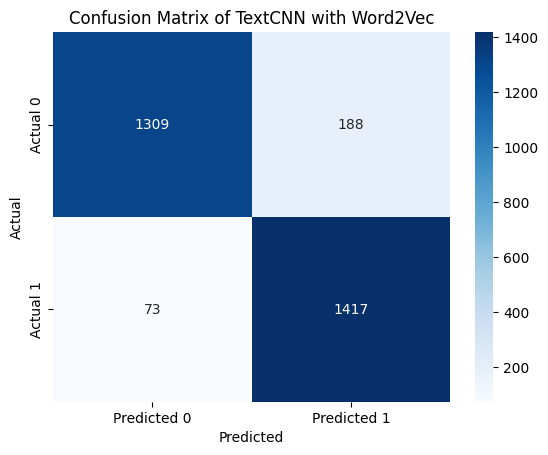

In [ ]:


# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of TextCNN with Word2Vec')
plt.show()



In [ ]:
# ROC curve
y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the model
model.save('word2vec_textcnn_model.h5')


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step


NameError: name 'roc_curve' is not defined